In [4]:
from network_analysis.geodf_network import GeoDataNetwork
import geopandas as gpd
from pathlib import Path
from geoprocessing.faf_zone_network import link_weights
import networkx as nx
import pandas as pd
import numpy as np

import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(0, Path.cwd().absolute())

BASE_DIR = Path.cwd().parent

In [54]:
ntad_nodes = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Nodes")
ntad_links = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Lines")

In [56]:
ntad_nodes = ntad_nodes.set_index('FRANODEID', drop=False)

In [5]:
faf_network_dir = BASE_DIR / 'resources/shapefiles/faf_network'

faf_links = gpd.GeoDataFrame.from_file(faf_network_dir / 'faf_links.shp')
faf_nodes = gpd.GeoDataFrame.from_file(faf_network_dir / 'faf_nodes.shp')

In [6]:
agg_network_dir = BASE_DIR / 'resources/shapefiles/agg_network'
agg_links = gpd.GeoDataFrame.from_file(agg_network_dir / 'agg_links.shp')
agg_nodes = gpd.GeoDataFrame.from_file(agg_network_dir / 'agg_nodes.shp')

In [60]:
ntad_geonet = GeoDataNetwork(ntad_nodes,ntad_links,'FRANODEID', lambda df : 0, lambda df : df[['FRFRANODE', 'TOFRANODE']])
ntad_railnet = ntad_geonet.createNetwork(NAME='NTAD')

/home/nathanczh/ctsm/faf_flow_assignment/src/network_analysis/geodf_network.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linksDf['weight'] = self.network_weight_fn(self.edgeDf)


In [66]:
for e in ntad_railnet.edges:
  print(ntad_railnet.nodes[e[1]])
  print(ntad_railnet.degree[e[1]])
  break

{'id': 300003, 'label': 300003, 'y': 20.881019629865722, 'x': -156.67863348557364}
2


In [19]:
faf_geonet = GeoDataNetwork(faf_nodes,faf_links,'FAF_Zone_1', lambda df : 0, lambda df : df[['FAF_Zone_f', 'FAF_Zone_t']])
faf_railnet = faf_geonet.createNetwork(NAME='FAF')

/home/nathanczh/ctsm/faf_flow_assignment/src/network_analysis/geodf_network.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linksDf['weight'] = self.network_weight_fn(self.edgeDf)


In [20]:
agg_geonet = GeoDataNetwork(agg_nodes,agg_links,'Node', lambda df : 0, lambda df : df[['Node_fr', 'Node_to']])
agg_railnet = agg_geonet.createNetwork(NAME='Aggregate')

/home/nathanczh/ctsm/faf_flow_assignment/src/network_analysis/geodf_network.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linksDf['weight'] = self.network_weight_fn(self.edgeDf)


,NTAD,FAF,Aggregate
Node Count,250436,268,101
Link Count,289309,285,226
Node Degrees,"{300000: 2, 300001: 1, 300002: 1, 300003: 2, 3...","{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...","{0: 0, 1: 4, 2: 4, 3: 3, 4: 3, 5: 5, 6: 3, 7: ..."
Mean Node Degree,2.310443,2.126866,4.475248
Connectivity,NaN,"{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0....","{0: 0.0, 1: 0.016616767913969828, 2: 0.0405625..."


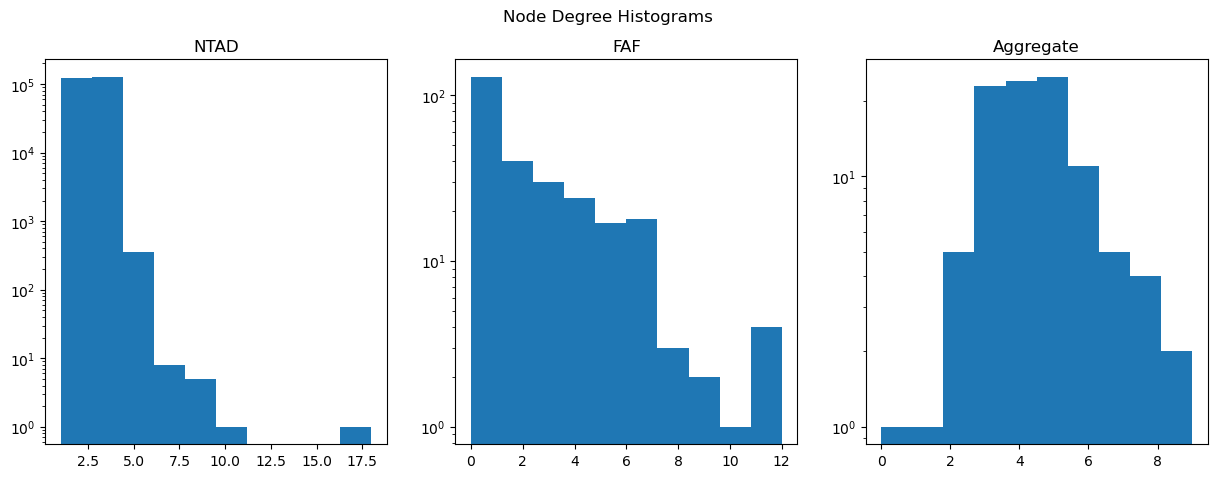

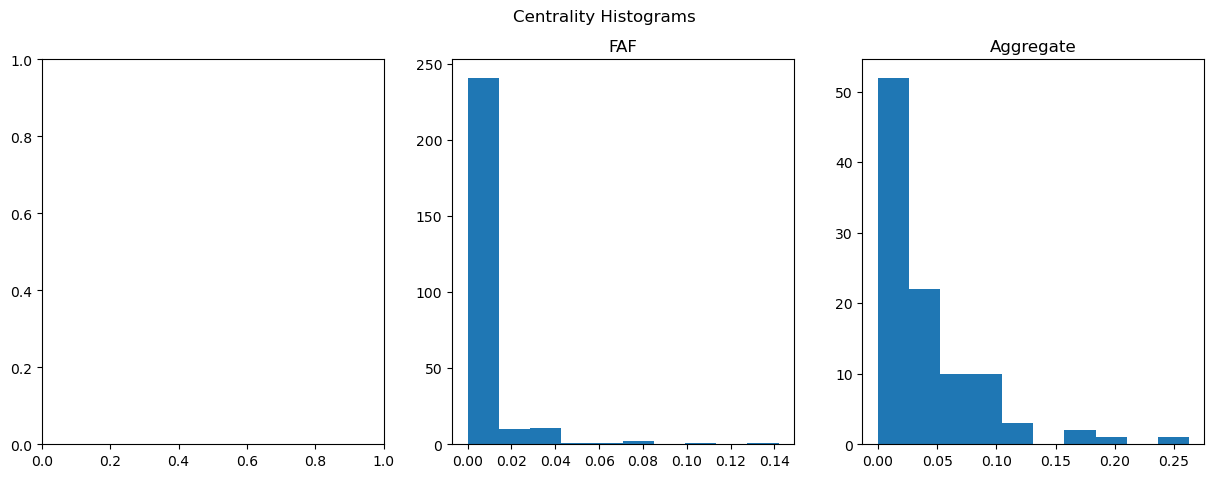

In [145]:
stats = []
import matplotlib.pyplot as plt

deg_fig, deg_axes = plt.subplots(1,3, figsize=(15,5))
deg_fig.suptitle('Node Degree Histograms')

conn_fig, conn_axes = plt.subplots(1,3, figsize=(15,5))
conn_fig.suptitle('Centrality Histograms')



i = 0
for name, net, geonet in (
  ('NTAD', ntad_railnet, ntad_geonet),
  ('FAF', faf_railnet, faf_geonet),
  ('Aggregate', agg_railnet, agg_geonet)
):
  stat = {}
  stat['Node Count'] =  len(net.nodes)
  stat['Link Count'] =  len(net.edges)
  stat['Node Degrees'] = dict(net.degree(net.nodes))
  stat['Mean Node Degree'] = np.array(list(stat['Node Degrees'].values())).mean()
  deg_axes[i].hist(list(stat['Node Degrees'].values()), log=True)
  deg_axes[i].set_title(name)

  if name != 'NTAD':
    stat['Connectivity'] = nx.betweenness_centrality(net)
    # display(stat['Connectivity'].values())
    # break
    conn_axes[i].hist(list(stat['Connectivity'].values()))
    conn_axes[i].set_title(name)
  
  # stat['Centrality'] = nx.degree_centrality(net)

  i += 1
  
  stats.append(stat)
  
stats_df = pd.DataFrame(stats, index=['NTAD', 'FAF', 'Aggregate']).T
stats_df

In [ ]:
import time

def EcNLPathTree(A, wn_PoDHa_data, Links, LINK_WEIGHT='PhysicalLe'):
    start = time.time()
    # Create a graph from the adjacency matrix
    GG = nx.Graph(A)
    n = GG.number_of_nodes()
    Connectedness = np.zeros((n, n))

    # Iterate through each pair of nodes
    for i in range(n):
        for j in range(i + 1, n):
            try:
                # Find all shortest paths between nodes i and j
                paths = list(nx.all_shortest_paths(GG, source=i, target=j, weight='weight'))
                total_connectedness = 0

                # Calculate connectedness for each shortest path
                for path_nodes in paths:
                    # Create edges from the path
                    path_edges = [(path_nodes[k], path_nodes[k + 1]) for k in range(len(path_nodes) - 1)]
                    # Sort each edge individually
                    path_edges_sorted = [tuple(sorted(edge)) for edge in path_edges]

                    e = np.isin(Links.iloc[:, :2].values, path_edges_sorted).all(axis=1)
                    f = np.sum(Links.loc[e, LINK_WEIGHT])
                    fn = np.sum(wn_PoDHa_data[path_nodes[:-1]])

                    # Calculate connectedness contribution of this path
                    total_connectedness += (f + fn) / ((len(path_nodes) * 2 - 1) * (len(path_nodes) - 1))

                # Average the connectedness over all shortest paths for this pair
                Connectedness[i, j] = total_connectedness / len(paths)

            except nx.NetworkXNoPath:
                # If there are no paths, set connectedness to 0
                Connectedness[i, j] = 0

    # Sum the connectedness values and compute the final result
    E_c = np.sum(Connectedness) * 2 / (n * (n - 1)) if n > 1 else 0  # Handle case where n <= 1
    end = time.time()
    length = end - start
    print("Time taken: ", length)
    return E_c

def connectivity(nodes_df, links_df, FR='Node_fr', TO='Node_to', NODE_WEIGHT='PopuWeight', LINK_WEIGHT='Physical L'):
  node_weights = nodes_df[NODE_WEIGHT].copy()
  Links = links_df[[FR, TO, LINK_WEIGHT]]
  link_nodes = links_df[[FR, TO]]
  used_nodes = set(links_df[FR]).union(set(links_df[TO]))
  unique_nodes = np.unique(link_nodes)
  n = len(unique_nodes)

  # Create graphs using networkx
  G = nx.Graph()
  Gw = nx.Graph()
  # Adding nodes first (from both start and end nodes)
  
  G.add_nodes_from(used_nodes)
  Gw.add_nodes_from(used_nodes)
  # Adding edges to the graph
  G.add_edges_from([(links_df[FR][i], links_df[TO][i]) for i in range(len(links_df))])
  Gw.add_weighted_edges_from([(links_df[FR][i], links_df[TO][i], links_df[LINK_WEIGHT][i]) for i in range(len(links_df))])

  # Calculate the adjacency matrix of Gw
  A = nx.to_numpy_array(Gw, weight='weight')

  # Compute the connectedness efficiency using EcNLPathTree function
  Connectedness_efficiency = EcNLPathTree(A, node_weights, links_df, LINK_WEIGHT=LINK_WEIGHT)
  print(f'Connectedness Efficiency: {Connectedness_efficiency}')

  # Compute Efficiency Impact on nodes
  indices = unique_nodes
  EfficiencyImpact_n = np.zeros(len(indices))

  for idx, i in enumerate(indices):
    A1 = A.copy()
    A1[i, :] = 0
    A1[:, i] = 0
    Connectedness_efficiency_new = EcNLPathTree(A1, node_weights, Links, LINK_WEIGHT=LINK_WEIGHT)
    EfficiencyImpact_n[idx] = (Connectedness_efficiency - Connectedness_efficiency_new) / Connectedness_efficiency
    print(f'{idx + 1}: {Connectedness_efficiency_new}')
  # Compute Efficiency Impact on links
  EfficiencyImpact_l = np.zeros(len(Links))

  # Convert the results to pandas DataFrames
  node_efficiency_impact_df = pd.DataFrame({
      'Node': list(range(len(EfficiencyImpact_n))),  # Node indices
      'Efficiency Impact': EfficiencyImpact_n
  })

  for i in range(len(Links)):
      A1 = A.copy()
      A1[link_nodes[FR][i], link_nodes[TO][i]]= 0
      A1[link_nodes[TO][i], link_nodes[FR][i]] = 0
      Connectedness_efficiency_new = EcNLPathTree(A1, node_weights, Links, LINK_WEIGHT=LINK_WEIGHT)
      EfficiencyImpact_l[i] = (Connectedness_efficiency - Connectedness_efficiency_new) / Connectedness_efficiency
      print(f'{i + 1}')

  link_efficiency_impact_df = pd.DataFrame({
      'Link (from, to)': list(link_nodes.iloc[:, :2].values),  # Links as tuples of (from, to)
      'Efficiency Impact': EfficiencyImpact_l
  })

  return node_efficiency_impact_df, link_efficiency_impact_df

connectivity(agg_nodes, agg_links)

Time taken:  8.401637077331543
Connectedness Efficiency: 0.02707001661479004
Time taken:  4.465556621551514
1: 0.026249365265451373
Time taken:  4.102457046508789
2: 0.026400136165496888
Time taken:  4.3570396900177
3: 0.026697127089784348
Time taken:  4.586854696273804
4: 0.02674168615577717
Time taken:  4.277991771697998
5: 0.02682790844289261
Time taken:  4.289111852645874
6: 0.026661000970734126
Time taken:  4.815952301025391
7: 0.0261921887584489
Time taken:  4.885342597961426
8: 0.026205005793192356
Time taken:  4.63211464881897
9: 0.026213502487783553
Time taken:  4.007719039916992
10: 0.02722551091249956
Time taken:  4.213807582855225
11: 0.02727333304771957
Time taken:  4.3396172523498535
12: 0.026713026075914324
Time taken:  4.690174102783203
13: 0.026629231775392514
Time taken:  4.616818189620972
14: 0.02680371985374232
Time taken:  10.37701940536499
15: 0.02646685083239698
Time taken:  10.738566398620605
16: 0.02592393685813251


KeyboardInterrupt: 

In [140]:
def EcNLPathTree(A, wn_PoDHa_data, Links, FR, TO, LINK_WEIGHT):
  GG = A
  start = time.time()
  # Create a graph from the adjacency matrix
  # GG = nx.Graph(A)
  n = GG.number_of_nodes()
  Connectedness = 0
  Links = Links.set_index([FR, TO])
  # display(Links.loc[(3,6), :])

  # Iterate through each pair of nodes

  for i in GG.nodes:
    for j in GG.nodes:
      if i >= j:
        continue
      try:
        paths = list(nx.all_shortest_paths(GG, source=i, target=j, weight='weight'))
  # all_paths = list(nx.all_pairs_all_shortest_paths(GG, weight='weight'))
  # for i, j_paths in all_paths:
  #   for j in j_paths:
  #     if i == j:
  #        continue
  #     try:
  #         paths = j_paths[j]
        total_connectedness = 0

        # Calculate connectedness for each shortest path
        for path_nodes in paths:
          path_edges = [(path_nodes[k], path_nodes[k + 1]) for k in range(len(path_nodes) - 1)]
          # Sort each edge individually
          path_edges_sorted = [(edge[1],edge[0])  if edge[1] < edge[0] else edge for edge in path_edges]
          print(path_edges_sorted)
          # e = np.isin(link_list, path_edges_sorted).all(axis=1)
          f = np.sum(Links.loc[path_edges_sorted, LINK_WEIGHT])
          fn = np.sum(wn_PoDHa_data[path_nodes[:-1]])

          # Calculate connectedness contribution of this path
          divided = (len(path_nodes) * 2 - 1) * (len(path_nodes) - 1)
          total_connectedness += (f + fn) / divided

          # Average the connectedness over all shortest paths for this pair
        Connectedness += total_connectedness / len(paths)

      except nx.NetworkXNoPath:
        # If there are no paths, set connectedness to 0
        # Connectedness += 0
        pass
  
  # Sum the connectedness values and compute the final result
  E_c = np.sum(Connectedness) * 2 / (n * (n - 1)) if n > 1 else 0  # Handle case where n <= 1
  end = time.time()
  length = end - start
  print("Time taken: ", length)
  return E_c

def connectivity(nodes_df, links_df, FR='Node_fr', TO='Node_to', NODE_WEIGHT='PopuWeight', LINK_WEIGHT='Physical L'):
  node_weights = nodes_df[NODE_WEIGHT].copy()
  Links = links_df[[FR, TO, LINK_WEIGHT]]
  link_nodes = links_df[[FR, TO]]
  used_nodes = set(links_df[FR]).union(set(links_df[TO]))
  unique_nodes = np.unique(link_nodes)
  n = len(unique_nodes)

  # Create graphs using networkx
  G = nx.Graph()
  Gw = nx.Graph()
  # Adding nodes first (from both start and end nodes)
  
  G.add_nodes_from(used_nodes)
  Gw.add_nodes_from(used_nodes)
  # Adding edges to the graph
  G.add_edges_from([(links_df[FR][i], links_df[TO][i]) for i in range(len(links_df))])
  Gw.add_weighted_edges_from([(links_df[FR][i], links_df[TO][i], links_df[LINK_WEIGHT][i]) for i in range(len(links_df))])

  # Calculate the adjacency matrix of Gw
  A = nx.to_numpy_array(Gw, weight='weight')
  
  # Compute the connectedness efficiency using EcNLPathTree function
  Connectedness_efficiency = EcNLPathTree(Gw, node_weights, links_df, FR, TO, LINK_WEIGHT=LINK_WEIGHT)
  print(f'Connectedness Efficiency: {Connectedness_efficiency}')
  return
  # Compute Efficiency Impact on nodes
  indices = unique_nodes
  EfficiencyImpact_n = np.zeros(len(indices))

  for idx, i in enumerate(indices):
    A1 = A.copy()
    A1[i, :] = 0
    A1[:, i] = 0
    Connectedness_efficiency_new = EcNLPathTree(A1, node_weights, Links, LINK_WEIGHT=LINK_WEIGHT)
    EfficiencyImpact_n[idx] = (Connectedness_efficiency - Connectedness_efficiency_new) / Connectedness_efficiency
    print(f'{idx + 1}: {Connectedness_efficiency_new}')
  # Compute Efficiency Impact on links
  EfficiencyImpact_l = np.zeros(len(Links))

  # Convert the results to pandas DataFrames
  node_efficiency_impact_df = pd.DataFrame({
      'Node': list(range(len(EfficiencyImpact_n))),  # Node indices
      'Efficiency Impact': EfficiencyImpact_n
  })

  for i in range(len(Links)):
      A1 = A.copy()
      A1[link_nodes[FR][i], link_nodes[TO][i]]= 0
      A1[link_nodes[TO][i], link_nodes[FR][i]] = 0
      Connectedness_efficiency_new = EcNLPathTree(A1, node_weights, Links, LINK_WEIGHT=LINK_WEIGHT)
      EfficiencyImpact_l[i] = (Connectedness_efficiency - Connectedness_efficiency_new) / Connectedness_efficiency
      print(f'{i + 1}')

  link_efficiency_impact_df = pd.DataFrame({
      'Link (from, to)': list(link_nodes.iloc[:, :2].values),  # Links as tuples of (from, to)
      'Efficiency Impact': EfficiencyImpact_l
  })

  return node_efficiency_impact_df, link_efficiency_impact_df

connectivity(agg_nodes, agg_links)

[(1, 2)]
[(1, np.int64(2)), (np.int64(2), 3)]
[(1, np.int64(2)), (np.int64(2), np.int64(3)), (np.int64(3), 4)]
[(1, np.int64(2)), (np.int64(2), 5)]
[(1, 6)]
[(1, 7)]
[(1, 8)]
[(1, np.int64(8)), (np.int64(8), 9)]
[(1, np.int64(8)), (np.int64(8), 10)]
[(1, np.int64(2)), (np.int64(2), np.int64(5)), (np.int64(5), 11)]
[(1, np.int64(2)), (np.int64(2), np.int64(5)), (np.int64(5), np.int64(11)), (np.int64(11), 12)]
[(1, np.int64(2)), (np.int64(2), np.int64(5)), (np.int64(5), np.int64(11)), (np.int64(11), np.int64(12)), (np.int64(12), 13)]
[(1, np.int64(8)), (np.int64(8), np.int64(10)), (np.int64(10), np.int64(18)), (14, np.int64(18))]
[(1, np.int64(6)), (np.int64(6), 15)]
[(1, np.int64(7)), (np.int64(7), 16)]
[(1, np.int64(8)), (np.int64(8), 17)]
[(1, np.int64(8)), (np.int64(8), np.int64(10)), (np.int64(10), 18)]
[(1, np.int64(7)), (np.int64(7), np.int64(16)), (np.int64(16), 19)]
[(1, np.int64(7)), (np.int64(7), np.int64(16)), (np.int64(16), np.int64(19)), (np.int64(19), 20)]
[(1, np.int64(8)

In [108]:
np.nan > 0

False

In [7]:
m = faf_links.explore(color='red')
faf_nodes.explore(m=m, color='red')


agg_nodes.explore(m=m, color='blue')
agg_links.explore(m=m, color='blue')
m